In [49]:
# settings
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import lsdb
import hipscat
import dask
from dask.distributed import Client
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.pipeline import pipeline_with_client
from hipscat.io import write_metadata
from hipscat.inspection import plot_points
import ray
from ray.util.dask import enable_dask_on_ray, disable_dask_on_ray
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [3]:
# to make sure epyc is safe from me
dask.config.set({'temporary_directory': '/astro/users/juliexue//root/users/juliexue/tmp'})

client = ray.init(
    num_cpus = 4
)
enable_dask_on_ray()

2024-02-12 19:05:47,914	INFO worker.py:1724 -- Started a local Ray instance.
/astro/users/juliexue/.conda/envs/python_3.10/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'shuffle' has been deprecated; please use 'dataframe.shuffle.algorithm' instead
  warnings.warn(


In [13]:
# import Gaia catalog
gaia = lsdb.read_hipscat("/data3/epyc/projects3/ivoa_demo/gaia/catalog")
tmp_dir_test="~/root/users/juliexue/tmp"

gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Npix,Dir
npartitions=3933,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,string,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,flo

In [5]:
# read data sets from other formats
# catalog of filtered stars from DELVE survey
# current length and size: 13827728 rows, 476MB
delve_data_dir = "/astro/users/juliexue/mydata/DELVE_dr1_area_selection_gr"
output_dir = "/astro/users/juliexue/mydata"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
%%time
args = ImportArguments(
    output_artifact_name="DELVE_hipscat",
#    input_path="~/mydata/DELVE_dr1_area_selection_gr",
    input_format="fits",
    input_file_list=["~/mydata/DELVE_dr1_area_selection_gr.fits"],
    ra_column="ra",
    dec_column="dec",
#    id_column="source_id",
    output_path=output_dir,
    dask_tmp="/astro/users/juliexue/root/users/juliexue/tmp",
    tmp_dir="/astro/users/juliexue/root/users/juliexue/tmp",
#    use_schema_file=f"{Path.home()}/mydata/DELVE_metadata",
#    manual_dtypes={'libname_gspphot':'unicode'},
    pixel_threshold=500_000,
    highest_healpix_order=5,
    overwrite=True
)

Planning  : 100%|██████████| 5/5 [00:00<00:00, 1025.05it/s]

tmp_path (/astro/users/juliexue/root/users/juliexue/tmp/DELVE_hipscat/intermediate) contains intermediate files. resuming prior progress.
CPU times: user 12.5 ms, sys: 4.21 ms, total: 16.7 ms
Wall time: 21.4 ms


In [8]:
%%time
with Client( 
    local_directory=args.dask_tmp,
    n_workers=4
) as client:
    pipeline_with_client(args, client)

/astro/users/juliexue/.conda/envs/python_3.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36006 instead
  warnings.warn(
Finishing : 100%|██████████| 5/5 [00:00<00:00, 21.88it/s]


CPU times: user 3.09 s, sys: 713 ms, total: 3.8 s
Wall time: 19.4 s


/astro/users/juliexue/hipscat/src/hipscat/catalog/partition_info.py:107: UserWarning: Reading partitions from parquet metadata. This is typically slow.
  warnings.warn("Reading partitions from parquet metadata. This is typically slow.")


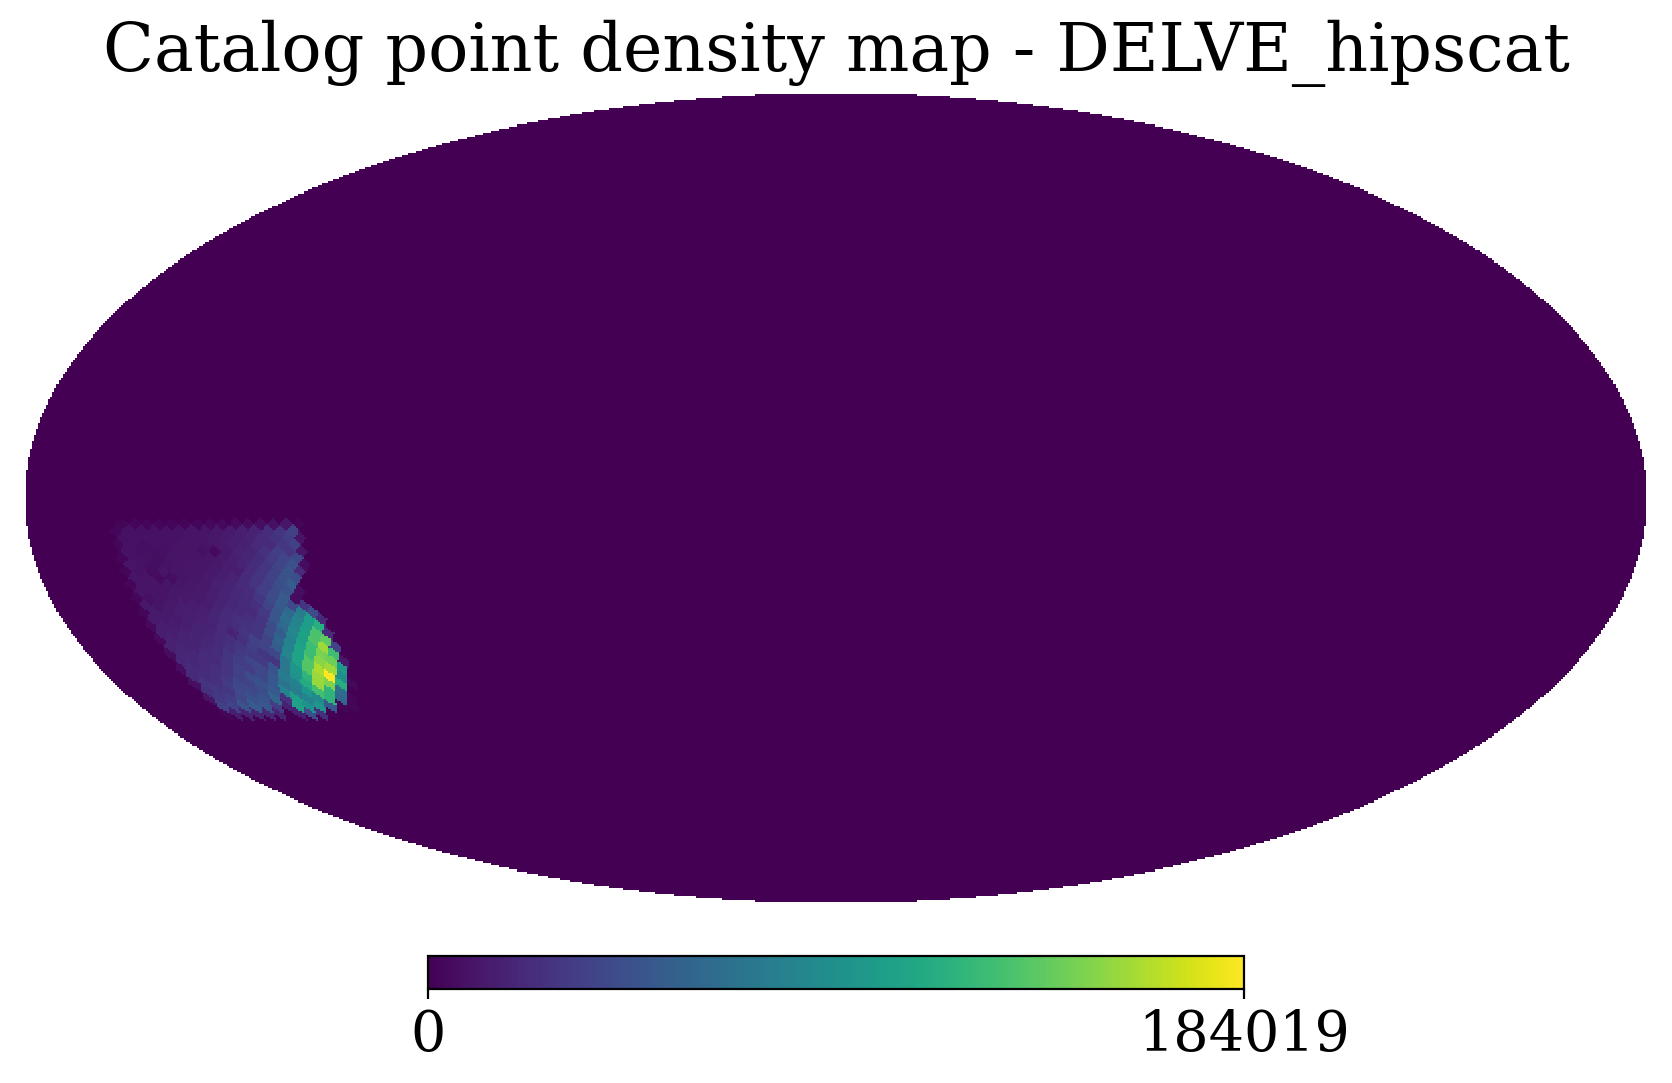

In [12]:
# check output file

delvehips = lsdb.read_hipscat(output_dir+"/DELVE_hipscat")

plot_points(delvehips.hc_structure)

Gaia EDR3 dataset (Gaia Collaboration et al. 2020). <br>
1. Angular cross match between the Gaia EDR3 dataset and DELVE DR1 with a matching radius of 0.005. <br>
This results in a catalog containing ∼ 143 million sources. 
2. Nearby sources are removed by applying a parallax cut of w − 3σ_w < 0.05. <br>
3. Cut on the renormalized unit weight error (ruwe) of ruwe < 1.4. <br>
4. Cut on BP_RP excess (operation with polynomial, see Riello et al. 2021 Eq.6). <br>
5. Only sources with astrometric_chi2_al < 2 are kept (avoid sources with bad astrometric fits.) <br>
6. Remove all sources that appear in the Gaia table gaiaedr3.agn cross id. <br>
7. Remove faint sources with G > 20 mag to avoid contamination.

In [42]:
# gaia cuts
gaia_sample = gaia.query('ruwe < 1.4')

In [52]:
%%time
# angular cross match between Gaia EDR3 and DELVE DR1
gaia_delve = delvehips.crossmatch(gaia_sample, radius_arcsec=0.5, suffixes=('_delve', '_gaia'))
matched = gaia_delve.compute()

/astro/users/juliexue/lsdb_clone/src/lsdb/dask/crossmatch_catalog_data.py:100: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 1min 11s, sys: 47.4 s, total: 1min 59s
Wall time: 7min 48s


In [53]:
matched

,ra_delve,dec_delve,gmag_delve,rmag_delve,spread_model_r_delve,extinction_g_delve,extinction_r_delve,Norder_delve,Dir_delve,Npix_delve,...,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Npix_gaia,Dir_gaia,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
6072282168636211200,120.528630,-12.358025,16.932556,16.510324,0.000207,0.294846,0.198045,0,0,5,...,0.0298,0.1216,0.0384,0.0162,0.0661,MARCS,4,1348,1348,0.000014
6072282435301670912,120.476793,-12.359786,16.743923,16.401424,0.000005,0.289288,0.194312,0,0,5,...,0.0661,0.1201,0.0507,0.0359,0.0653,MARCS,4,1348,1348,0.000017
6072282511910633472,120.504824,-12.358285,16.571968,16.166361,0.004824,0.292152,0.196235,0,0,5,...,0.1334,0.1757,0.0862,0.0727,0.0958,MARCS,4,1348,1348,0.000034
6072282517715550208,120.503559,-12.357876,16.941364,16.386429,0.000228,0.292051,0.196167,0,0,5,...,0.0218,0.0615,0.0230,0.0117,0.0330,MARCS,4,1348,1348,0.000011
6072282529111474176,120.493802,-12.358136,16.844004,16.028048,-0.000106,0.291043,0.195490,0,0,5,...,0.4834,0.5168,0.2668,0.2577,0.2756,MARCS,4,1348,1348,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11523166137005113344,129.659985,-5.011793,19.737736,19.394293,-0.000320,0.085741,0.057591,3,0,639,...,NaN,NaN,NaN,NaN,NaN,None,3,639,639,0.000004
11523166232962400256,129.646777,-5.007919,18.582216,18.181511,-0.000367,0.085941,0.057725,3,0,639,...,0.0011,0.0111,0.0024,0.0006,0.0061,MARCS,3,639,639,0.000010
11523166295050682368,129.663824,-5.000233,16.873585,16.470284,-0.000341,0.085001,0.057094,3,0,639,...,0.0004,0.0060,0.0010,0.0002,0.0033,MARCS,3,639,639,0.000004


In [35]:
# parallax cut 
# This can be incorporated in the crossmatch queries
#filtered = gaia_delve.query(
  #  "ruwe_gaia < 1.4 AND astrometric_chi2_al_gaia < 2")
#filtered

In [ ]:
# parallax cut 
gaia_delve = gaia_delve[gaia_delve['parallax'] - 3*gaia_delve['parallax_error'] < 0.05]

# ruwe cut
gaia_delve = gaia_delve[gaia_delve['ruwe'] < 1.4]

# some BP_RP excess cut
# same principle, needs a polynomial calculation

# Eliminate bad astrometric fits
gaia_delve = gaia_delve[gaia_delve['astrometric_chi2_al'] < 2]

# remove AGNs from the agn_cross_id table
# ADQL query, then subtract all these rows
gaia_delve = 

# remove sources too faint
gaia_delve = gaia_delve[gaia_delve['phot_g_mean_mag'] <= 20]

# further quality checks on crossmatching, e.g. mismatches?

## Plot

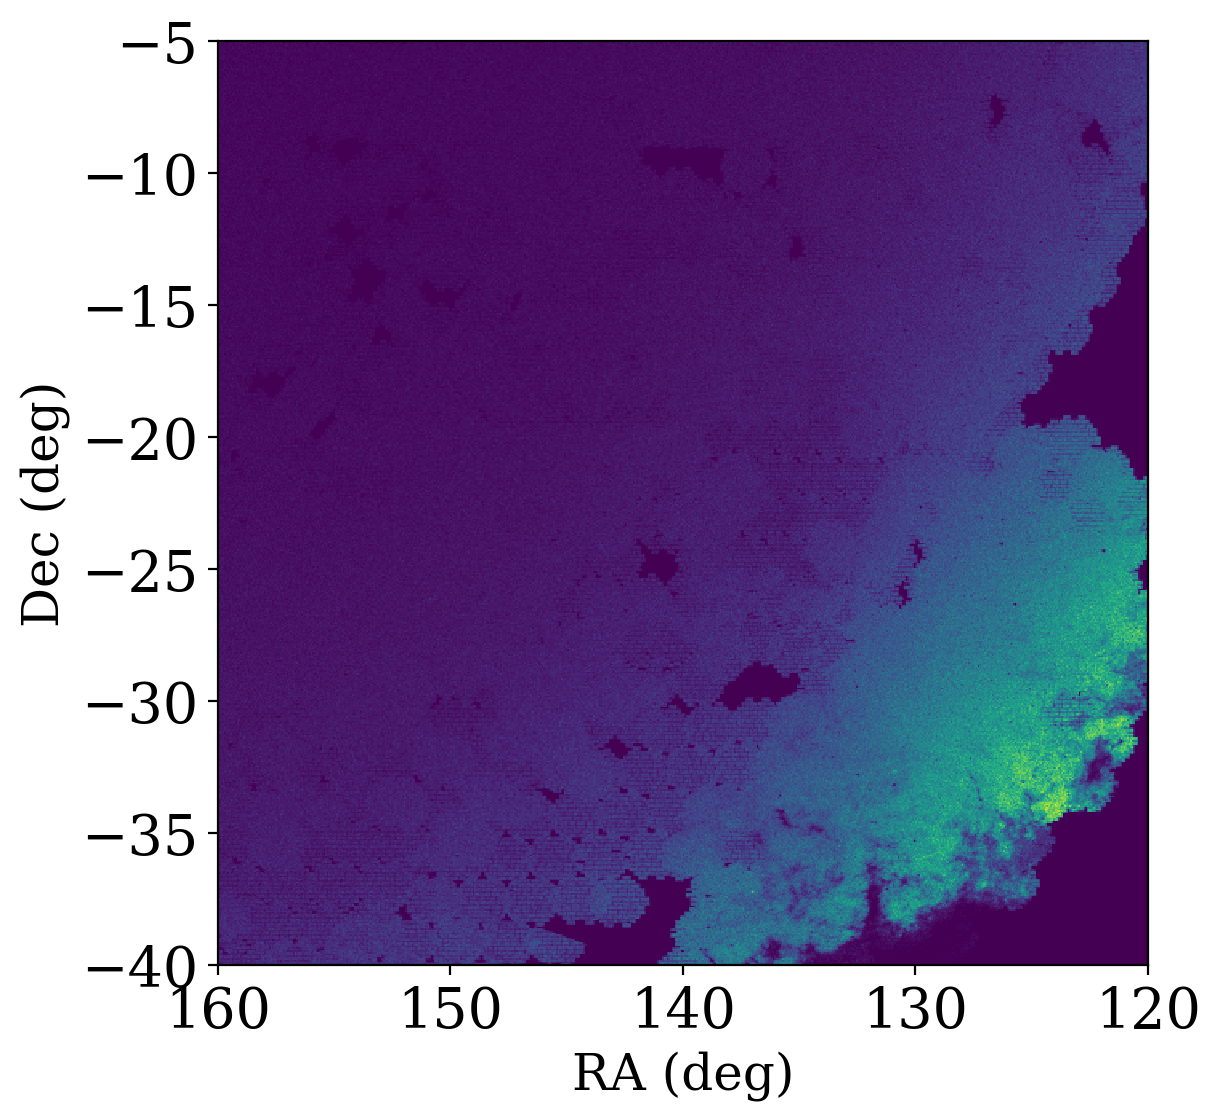

In [51]:
ra = matched['ra_gaia']
dec = matched['dec_gaia']

fig,ax = plt.subplots(1,1,figsize=(6,6))
kwargsdensity = dict(bins = 580)
plt.sca(ax)
plt.hist2d(ra,dec,**kwargsdensity)
plt.xlabel('RA (deg)',fontsize=18)
plt.ylabel('Dec (deg)',fontsize=18)
plt.xlim(160,120)
plt.show()

In [54]:
disable_dask_on_ray()
ray.shutdown()

/astro/users/juliexue/.conda/envs/python_3.10/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'shuffle' has been deprecated; please use 'dataframe.shuffle.algorithm' instead
  warnings.warn(
